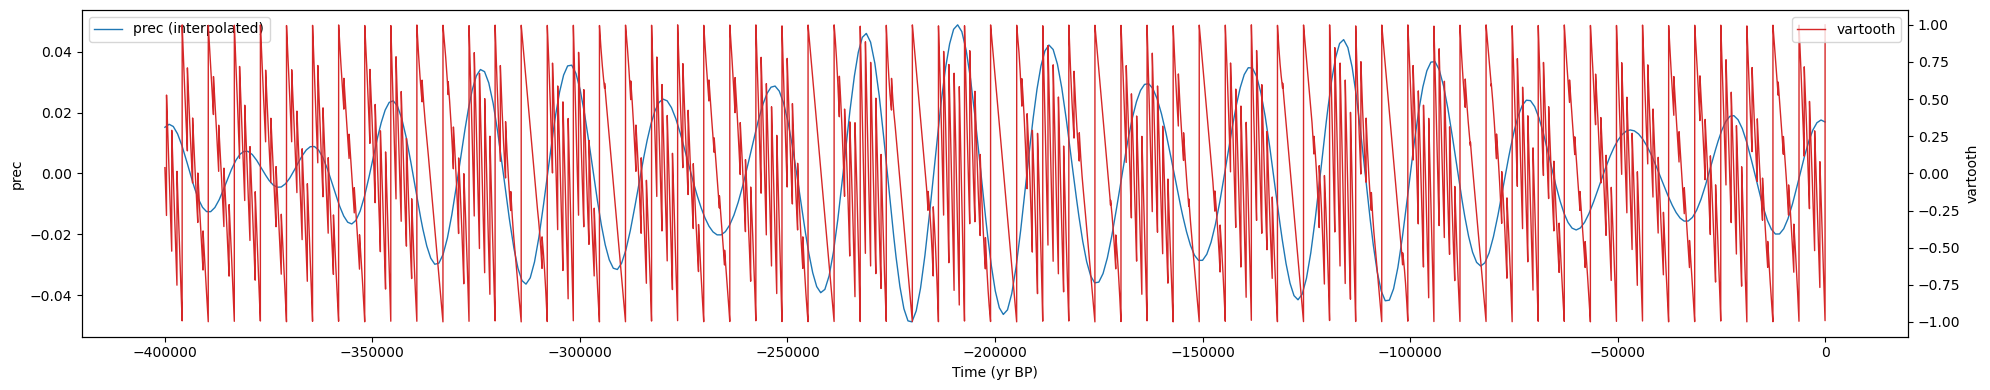

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import sawtooth
from scipy.interpolate import interp1d


df = pd.read_excel("other_data/orbit91.xlsx", header=None, skiprows=1).dropna(how="all")
orbit = df.to_numpy(dtype=float)

# -------------------------------------------------------------------
# 2. EXTRACT COLUMNS (MATLAB is 1-based, Python is 0-based)
# -------------------------------------------------------------------
years_kyr = orbit[:, 0]              # col-1  (kyr BP in many orbital datasets)
years     = years_kyr * 1000.0       # convert → yr BP to match MATLAB
prec_raw  = orbit[:, 4]              # col-5  (MATLAB orbit91(:,5))

# Sort the x–axis so the interpolator is happy
order = np.argsort(years)
years, prec_raw = years[order], prec_raw[order]

# -------------------------------------------------------------------
# 3. REGULAR TIME GRID
# -------------------------------------------------------------------
dt, tstart, tend = 10.0, -400_000.0, 0.0
time = np.arange(tstart, tend + dt, dt)

# -------------------------------------------------------------------
# 4. INTERPOLATE WITH EXTRAPOLATION (faithful MATLAB interp1 replacement)
# -------------------------------------------------------------------
prec = interp1d(
    years, prec_raw,
    kind="linear",
    fill_value="extrapolate",
    bounds_error=False
)(time)

# -------------------------------------------------------------------
# 5. SAWTOOTH COMPONENTS
# -------------------------------------------------------------------
finetoothed   = -sawtooth(time /  200.0)
medtoothed    = -sawtooth(time / 1000.0)
coarsetoothed = -sawtooth(time / 1000.0)   # MATLAB used the same period

# -------------------------------------------------------------------
# 6. WEIGHTING
# -------------------------------------------------------------------
prec_range = np.ptp(prec)            # peak-to-peak == range(prec)

if prec_range == 0:                  # protect against divide-by-zero
    raise ValueError("Interpolated 'prec' is constant -- check the input data.")

prec_scaling_parameter = 1.0
fineweight = np.clip(0.25 + prec / (prec_range * prec_scaling_parameter), 0.0, None)
medweight  = np.zeros_like(fineweight)
coarseweight = 1.0 - fineweight

vartooth = (fineweight   * finetoothed +
            medweight    * medtoothed +
            coarseweight * coarsetoothed)

# -------------------------------------------------------------------
# 7. PLOT (Matplotlib twin-y axis = MATLAB yyaxis)
# -------------------------------------------------------------------
fig, ax1 = plt.subplots(figsize=(20, 4))
ax2 = ax1.twinx()

ax1.plot(time, prec,        lw=1, label="prec (interpolated)")
ax2.plot(time, vartooth,    lw=1, label="vartooth", color="tab:red")

ax1.set_xlabel("Time (yr BP)")
ax1.set_ylabel("prec")
ax2.set_ylabel("vartooth")

# fig.suptitle("Interpolated Precision & Variable-Tooth Signal")
ax1.legend(loc="upper left")
ax2.legend(loc="upper right")
fig.tight_layout()
plt.show()


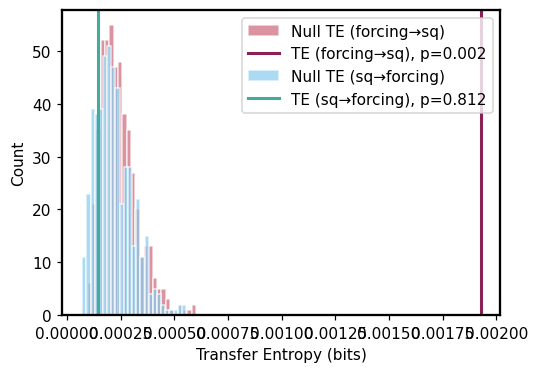


Is information flow significant only in the prec → vartooth direction?
Result: True


In [19]:
from toolbox import sq_ana as sa 
import importlib
importlib.reload(sa)


te_data = np.column_stack((time, prec, vartooth))   # shape (N, 3)

forcing = prec.copy()       # “driver” series
sq      = vartooth.copy()   # “response” series
forcing = forcing[::-1]
sq      = sq[::-1]           # reverse to match MATLAB's direction

unidir_prec_to_vartooth, fig = sa.transfer_entropy_surrogate_test(
    forcing      = forcing,
    sq           = sq,
    k            = 1,        # history length (same as your default)
    forcing_bins = 6,        # per your request
    sq_bins      = 2,        # per your request
    n_surr       = 500,      # number of shuffled surrogates
    p            = 0.05,     # significance level
    sq_method    = 'hist',   # or 'quantile' / 'kmeans'
    if_plot      = True,     # show histograms
    dpi          = 110
)

print("\nIs information flow significant only in the prec → vartooth direction?")
print("Result:", unidir_prec_to_vartooth)


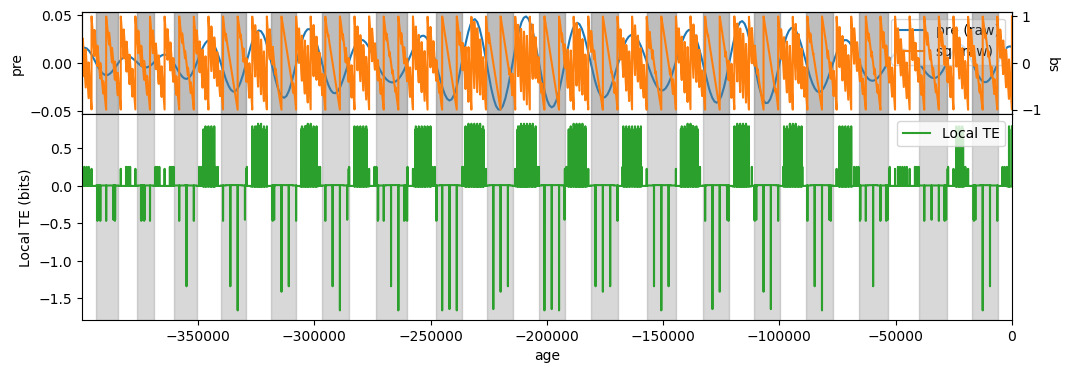

First 10 local TE values: [[-0.00256839 -0.00256839 -0.00256839 ... -0.00979422 -0.00979422
   0.79231499]]


In [2]:
from toolbox import sq_ana as sa 
import importlib
importlib.reload(sa)


import pandas as pd



forcing = prec.copy()       # “driver” series
sq      = vartooth.copy()   # “response” series
forcing = forcing[::-1]
sq      = sq[::-1]           # reverse to match MATLAB's direction

time=time[::-1]  # reverse time to match MATLAB's direction

df_pre = pd.DataFrame({
    "age": time,       # time axis (same length as prec)
    "pre": forcing        # forcing series
})

df_sq = pd.DataFrame({
    "age": time,
    "sq":  sq    # target/response series
})

# ---------------------------------------------------------------------
# 2.  Call the local-TE routine
# ---------------------------------------------------------------------
local_te_values = sa.local_TE(
    df_pre          = df_pre,
    df_sq           = df_sq,
    forcing_column  = "pre",     # default; shown for clarity
    target_column   = "sq",
    time_column     = "age",
    nbins_pre       = 6,         # or any integer ≥2
    nbins_target    = 2          # this param isn’t used in the
                                 # current local_TE code, but you
                                 # can leave it in for completeness
)

# local_te_values is a NumPy vector of local TE estimates
print("First 10 local TE values:", local_te_values[:10])


Running TE tests …
p_hi=1/10   p_lo=1/110  →  sig=True
p_hi=1/20   p_lo=1/110  →  sig=True
p_hi=1/30   p_lo=1/110  →  sig=True
p_hi=1/40   p_lo=1/110  →  sig=True
p_hi=1/50   p_lo=1/110  →  sig=True
p_hi=1/60   p_lo=1/110  →  sig=True
p_hi=1/70   p_lo=1/110  →  sig=True
p_hi=1/80   p_lo=1/110  →  sig=True
p_hi=1/90   p_lo=1/110  →  sig=False
p_hi=1/10   p_lo=1/120  →  sig=True
p_hi=1/20   p_lo=1/120  →  sig=True
p_hi=1/30   p_lo=1/120  →  sig=True
p_hi=1/40   p_lo=1/120  →  sig=True
p_hi=1/50   p_lo=1/120  →  sig=True
p_hi=1/60   p_lo=1/120  →  sig=False
p_hi=1/70   p_lo=1/120  →  sig=True
p_hi=1/80   p_lo=1/120  →  sig=False
p_hi=1/90   p_lo=1/120  →  sig=False
p_hi=1/10   p_lo=1/130  →  sig=True
p_hi=1/20   p_lo=1/130  →  sig=True
p_hi=1/30   p_lo=1/130  →  sig=True
p_hi=1/40   p_lo=1/130  →  sig=True
p_hi=1/50   p_lo=1/130  →  sig=True
p_hi=1/60   p_lo=1/130  →  sig=True
p_hi=1/70   p_lo=1/130  →  sig=True
p_hi=1/80   p_lo=1/130  →  sig=True
p_hi=1/90   p_lo=1/130  →  sig=False
p_hi

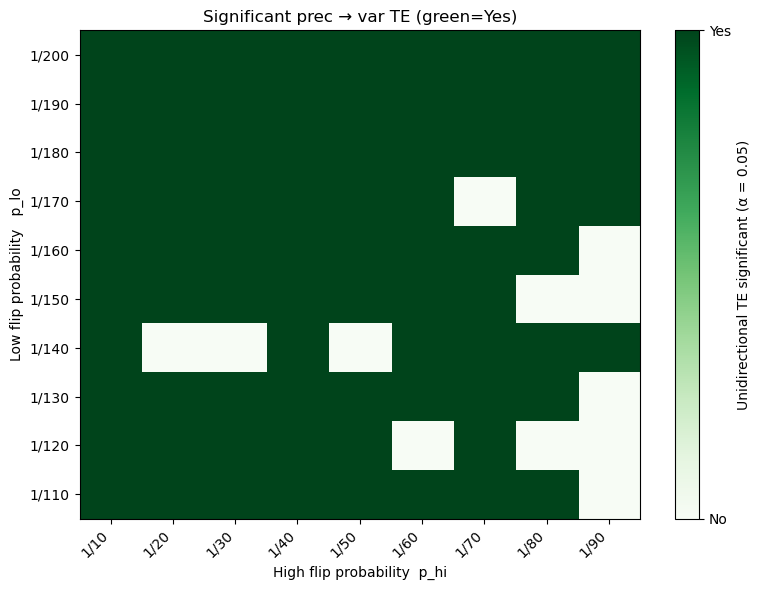

In [40]:
# ================================================================
# 0.  libraries & toolbox
# ================================================================
import numpy as np
import matplotlib.pyplot as plt
from toolbox import sq_ana as sa
import importlib; importlib.reload(sa)

# ================================================================
# 1.  fixed parameters for the two-state “var” generator
# ================================================================
state_amp  = 1.0
noise_sd   = 0.05         # jitter around ±state_amp
p_base     = 1.0 / 100    # default flip probability (≈100-point mean wait)

# build prec_normalised once
prec_norm = (prec - prec.min()) / (prec.max() - prec.min())
N         = len(prec)

# ================================================================
# 2.  sweep grids for p_hi and p_lo
#     p_hi : 1/10 … 1/90   (step 10 in the denominator)
#     p_lo : 1/110 … 1/200 (step 10 in the denominator)
# ================================================================
p_hi_den  = np.arange(10, 91, 10)      # [10,20,...,90]
p_lo_den  = np.arange(110, 201, 10)    # [110,120,...,200]

p_hi_vals = 1.0 / p_hi_den
p_lo_vals = 1.0 / p_lo_den

sig_mat   = np.zeros((len(p_lo_vals), len(p_hi_vals)), dtype=int)   # 1=True, 0=False

# ---------------------------------------------------------------
def generate_var(p_hi, p_lo, seed):
    """
    Two-state Markov series with prec-modulated flip probability.
    """
    rng    = np.random.default_rng(seed)
    var    = np.empty(N)
    state  = 1.0
    for i in range(N):
        var[i] = state + rng.normal(scale=noise_sd)
        # choose flip‐prob for this time step
        pn = prec_norm[i]
        if pn <= 2/6:
            p_flip = p_lo
        elif 3/6 < pn <= 4/6:
            p_flip = p_hi
        else:
            p_flip = p_base
        if rng.random() < p_flip:
            state *= -1.0
    return var

# ---------------------------------------------------------------
print("Running TE tests …")
for r, p_lo in enumerate(p_lo_vals):
    for c, p_hi in enumerate(p_hi_vals):
        # reproducible but different rng for every combo
        seed = 2025 + r*100 + c
        var   = generate_var(p_hi, p_lo, seed=seed)

        # reverse series to match MATLAB convention
        forcing = prec[::-1]
        sq      = var[::-1]

        sig, _ = sa.transfer_entropy_surrogate_test(
            forcing      = forcing,
            sq           = sq,
            k            = 1,
            forcing_bins = 6,
            sq_bins      = 2,
            n_surr       = 500,      # adjust if you need speed
            p            = 0.05,
            sq_method    = 'hist',
            if_plot      = False
        )
        sig_mat[r, c] = int(sig)
        print(f"p_hi=1/{p_hi_den[c]:<3}  p_lo=1/{p_lo_den[r]:<3}  →  sig={sig}")

# ================================================================
# 3.  visualise the True/False grid
# ================================================================
fig, ax = plt.subplots(figsize=(8, 6))
im = ax.imshow(sig_mat,
               origin="lower",
               cmap="Greens",
               aspect="auto",
               vmin=0, vmax=1)

# axis ticks & labels
ax.set_xticks(np.arange(len(p_hi_den)))
ax.set_yticks(np.arange(len(p_lo_den)))
ax.set_xticklabels([f"1/{d}" for d in p_hi_den])
ax.set_yticklabels([f"1/{d}" for d in p_lo_den])
plt.setp(ax.get_xticklabels(), rotation=45, ha="right")
ax.set_xlabel("High flip probability  p_hi")
ax.set_ylabel("Low flip probability   p_lo")
ax.set_title("Significant prec → var TE (green=Yes)")

# colourbar: 1 = significant
cbar = fig.colorbar(im, ax=ax, ticks=[0, 1])
cbar.ax.set_yticklabels(["No", "Yes"])
cbar.set_label("Unidirectional TE significant (α = 0.05)")

plt.tight_layout()
plt.show()


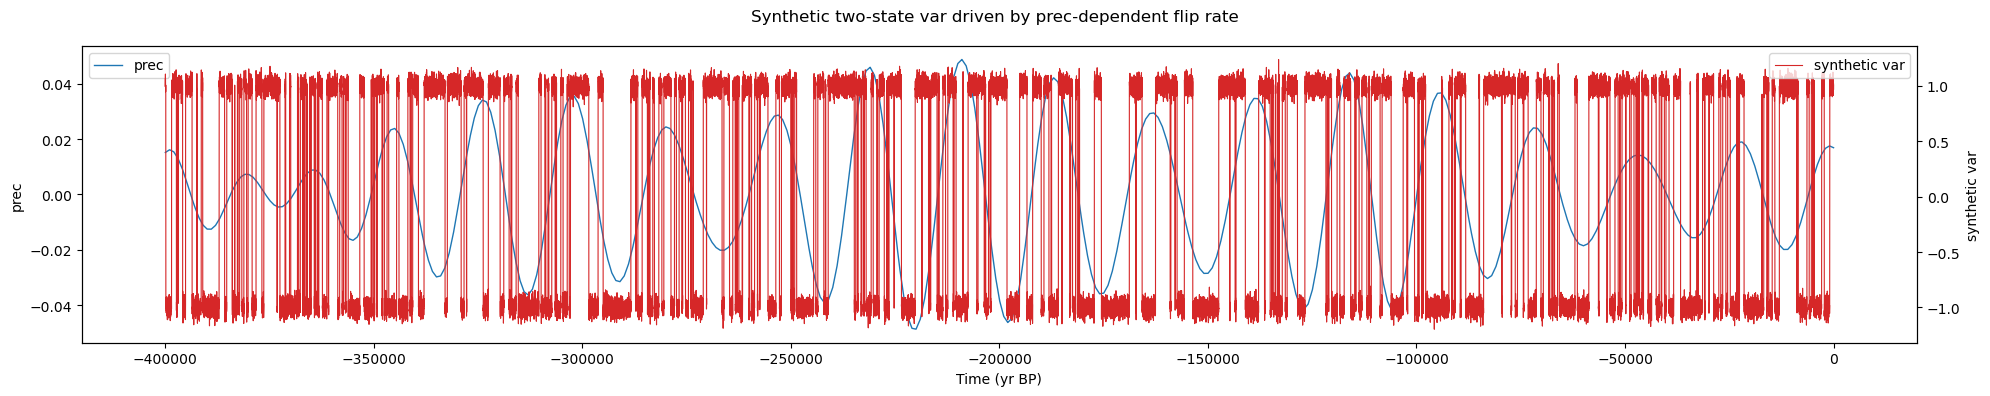

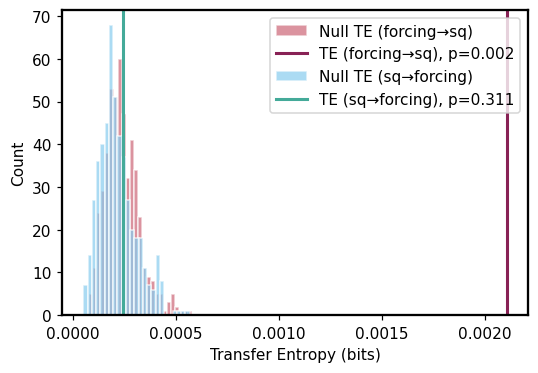


Unidirectional significance (prec → var only)?  True


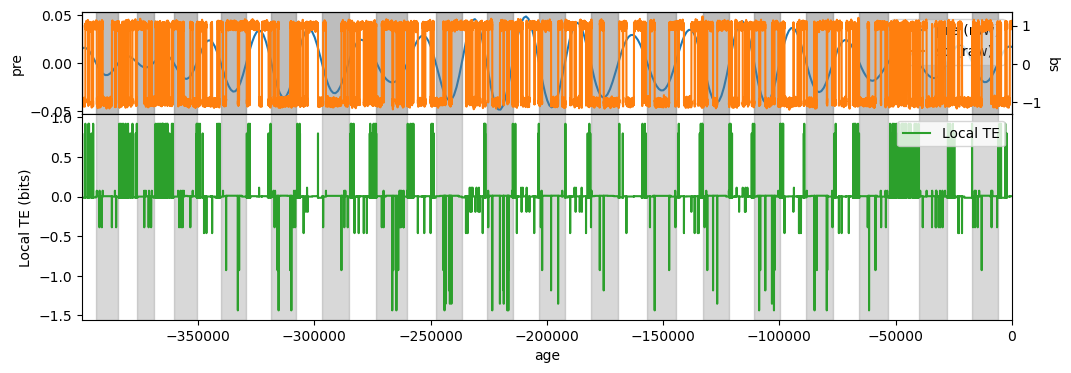

First 10 local-TE values: [[-0.0118951  -0.0118951  -0.0118951  ...  0.00439759  0.00439759
   0.00439759]]


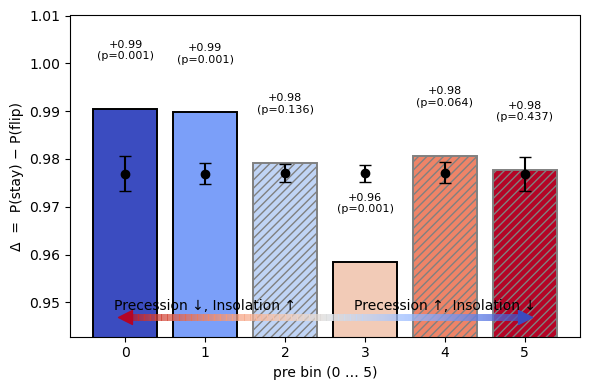

In [ ]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# ---------------------------------------------------------------
# 1.  PARAMETERS FOR THE TWO-STATE PROCESS
# ---------------------------------------------------------------
np.random.seed(2025)

state_amp   = 1.0      # |value| when above / below zero
noise_sd    = 0.05     # small jitter around ±state_amp
# baseline flip probability → mean residence ≈100 points
p_base      = 1.0 / 100
# high- and low-flip probabilities (favoured / suppressed windows)
p_hi        = 1.0 / 50     # mean wait ≈50 points
p_lo        = 1.0 / 200    # mean wait ≈200 points

# ---------------------------------------------------------------
# 2.  NORMALISE prec TO [0, 1] AND DEFINE THE WINDOWS
# ---------------------------------------------------------------
prec_norm = (prec - prec.min()) / (prec.max() - prec.min())

def flip_prob(pn):
    """
    Piece-wise flip probability as a function of normalised prec.
    """
    if pn <= 2/6:
        return p_lo         # suppressed flipping
    elif 3/6 < pn <= 4/6:
        return p_hi         # favoured flipping
    else:
        return p_base       # default

# ---------------------------------------------------------------
# 3.  SYNTHETIC var:  TWO-STATE MARKOV WITH prec-MODULATED FLIPS
# ---------------------------------------------------------------
N = len(prec)
var = np.zeros(N)

state = 1.0                        # start in the “warm” (+) state
for i in range(N):
    # store current state with a dash of white noise
    var[i] = state + np.random.normal(scale=noise_sd)
    # decide whether to flip for next time step
    if np.random.rand() < flip_prob(prec_norm[i]):
        state *= -1.0              # flip ±1

# ---------------------------------------------------------------
# 4.  PLOT prec (blue) AND var (red)
# ---------------------------------------------------------------
fig, ax1 = plt.subplots(figsize=(20, 4))
ax2 = ax1.twinx()

ax1.plot(time, prec, lw=1, label='prec')
ax2.plot(time, var,  color='tab:red', lw=0.8, label='synthetic var')

ax1.set_xlabel('Time (yr BP)')
ax1.set_ylabel('prec')
ax2.set_ylabel('synthetic var')
fig.suptitle('Synthetic two-state var driven by prec-dependent flip rate')
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')
plt.tight_layout()
plt.show()

# ---------------------------------------------------------------
# 5.  TRANSFER-ENTROPY ANALYSIS (series reversed for MATLAB style)
# ---------------------------------------------------------------
from toolbox import sq_ana as sa
import importlib; importlib.reload(sa)

forcing = prec[::-1]     # driver  (prec)
sq      = var[::-1]      # target  (synthetic var)
time    = time[::-1]    # reverse time to match MATLAB's direction

# 5.1  Surrogate-test TE (global)
unidir_prec_to_var, fig_te = sa.transfer_entropy_surrogate_test(
    forcing      = forcing,
    sq           = sq,
    k            = 1,
    forcing_bins = 6,
    sq_bins      = 2,
    n_surr       = 500,
    p            = 0.05,
    sq_method    = 'hist',
    if_plot      = True,
    dpi          = 110
)
print("\nUnidirectional significance (prec → var only)? ",
      unidir_prec_to_var)

# 5.2  Local-TE track
df_pre = pd.DataFrame({"age": time, "pre": forcing})
df_sq  = pd.DataFrame({"age": time, "sq":  sq})

local_te_vals = sa.local_TE(
    df_pre          = df_pre,
    df_sq           = df_sq,
    forcing_column  = "pre",
    target_column   = "sq",
    time_column     = "age",
    nbins_pre       = 6,
    nbins_target    = 2
)
print("First 10 local-TE values:", local_te_vals[:10])




delta, mu, sigma, p = sa.prob_prebins_diffbar_surr(
        df_pre, df_sq,
        forcing_column='pre',
        target_column='sq',
        nbins_pre=6,
        n_surr=1000,
        alpha=0.05,
        random_state=0   # reproducible
)



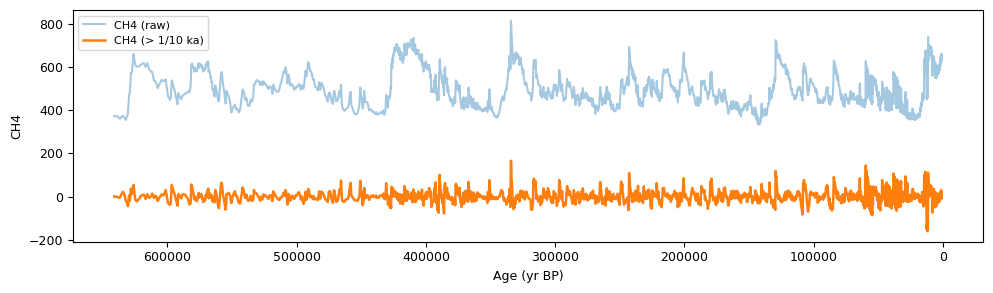

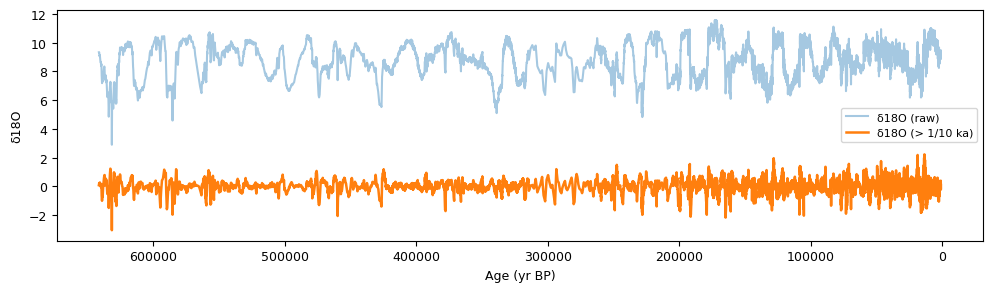

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from toolbox import sq_ana as sa 
import importlib
importlib.reload(sa)


# 0) Load raw data
df_ch4 = pd.read_excel('other_data/CH4_AICC2023.xlsx', sheet_name='Sheet1')
file_path = r"D:\VScode\bipolar_seesaw_CCM\other_data\monsoon.xlsx"
df_d18O = pd.read_excel(file_path)
df_d18O['age'] *= 1000  # to yrs BP
df_d18O['d18O'] = df_d18O['d18O'].values*-1
# renmae column d18O to 'd18O*-1'
df_d18O.rename(columns={'d18O': '-d18O'}, inplace=True)

dt=10
# 1) Build common 10-yr age grid over their overlap
age_min = 1000 # max(df_ch4['age'].min(), df_d18O['age'].min())
age_max = min(df_ch4['age'].max(), df_d18O['age'].max())
ages = np.arange(age_min, age_max + 1, dt)

# 2) Interpolate each onto that grid
ch4 = np.interp(ages, df_ch4['age'], df_ch4['ch4'])
d18O = np.interp(ages, df_d18O['age'], df_d18O['-d18O'])



df_ch4_interp = pd.DataFrame({'age':ages, 'ch4':ch4})
df_d18O_interp = pd.DataFrame({'age':ages, 'd18O':d18O})

df_filt_ch4, df_filt_d18O = sa.highpass_ch4_d18O(
    df_ch4_interp,          # DataFrame with columns ['age','ch4']
    df_d18O_interp,         # columns ['age','d18O']
    cutoff_period = 10000, # high-pass >1/10 ka
    plot = True             # quick comparison plot
)


df_sq_i, df_pre_i, df_obl_i = sa.interpolate_data_forcing(df_filt_ch4.copy(), 50, if_plot=False)




prec = df_pre_i['pre'].values      # source (precession)
time = df_pre_i['age'].values      # time axis (yr BP)


Number of 0 → 1 transitions: 255
Number of 1 → 0 transitions: 256


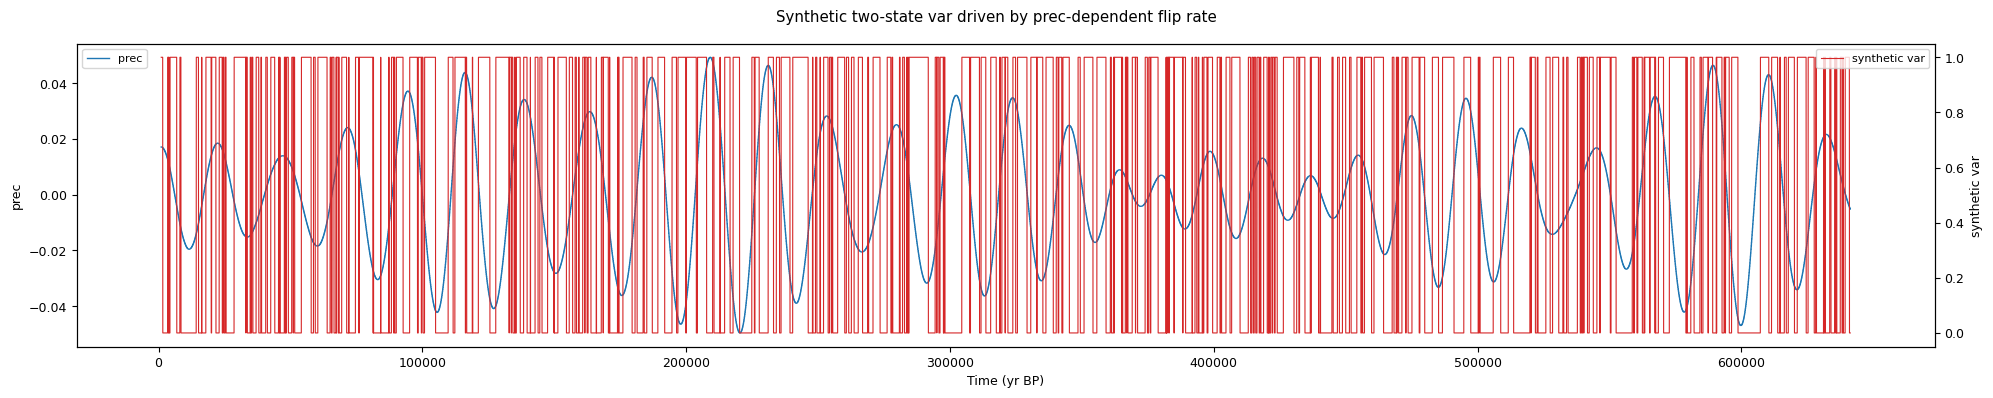

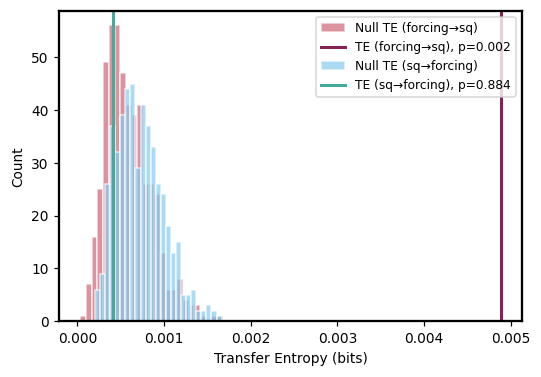


Unidirectional significance (prec → var only)?  True


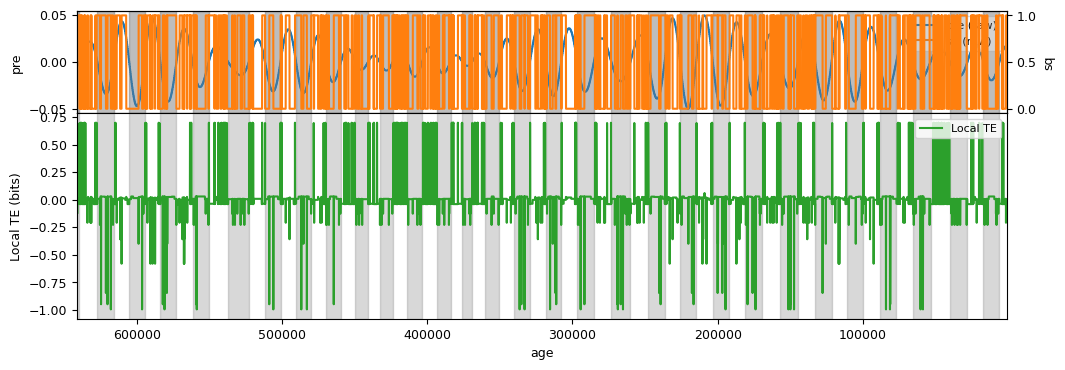

First 10 local-TE values: [[ 0.00525983  0.00525983  0.00525983 ... -0.00105327 -0.00105327
  -0.00105327]]


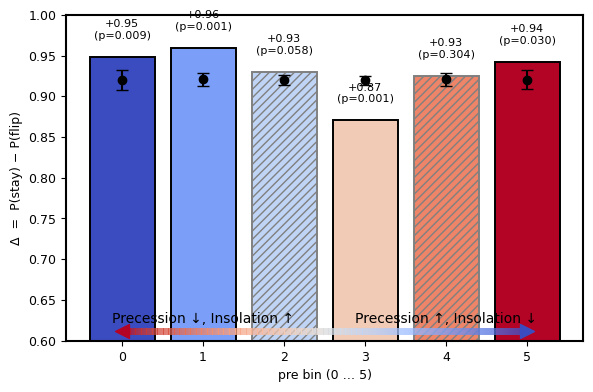

In [12]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


np.random.seed(2025)

state_amp   = 1.0      # |value| when above / below zero
noise_sd    = 0     # small jitter around ±state_amp
# baseline flip probability → mean residence ≈100 points
p_base      = 1.0 / 28
# high- and low-flip probabilities (favoured / suppressed windows)
p_hi        = 1.0 / 14     # mean wait ≈50 points
p_lo        = 1.0 / 56    # mean wait ≈200 points

# ---------------------------------------------------------------
# 2.  NORMALISE prec TO [0, 1] AND DEFINE THE WINDOWS
# ---------------------------------------------------------------
prec_norm = (prec - prec.min()) / (prec.max() - prec.min())

def flip_prob(pn):
    """
    Piece-wise flip probability as a function of normalised prec.
    """
    if pn <= 2/6:
        return p_lo         # suppressed flipping
    elif 3/6 < pn <= 4/6:
        return p_hi         # favoured flipping
    else:
        return p_base       # default

# ---------------------------------------------------------------
# 3.  SYNTHETIC var:  TWO-STATE MARKOV WITH prec-MODULATED FLIPS
# ---------------------------------------------------------------
N = len(prec)
var = np.zeros(N)

state = 1.0                        # start in the “warm” (+) state
for i in range(N):
    # store current state with a dash of white noise
    var[i] = state + np.random.normal(scale=noise_sd)
    # decide whether to flip for next time step
    if np.random.rand() < flip_prob(prec_norm[i]):
        state = -state               # flip 

# replace all -1 in var with 0
var[var < 0] = 0

# print the number of 0-1 and 1-0 transitions
transitions = np.diff(var)
num_01 = np.sum(transitions == 1)  # 0 → 1 transitions
num_10 = np.sum(transitions == -1) # 1 → 0 transitions
print(f"Number of 0 → 1 transitions: {num_01}")
print(f"Number of 1 → 0 transitions: {num_10}")



fig, ax1 = plt.subplots(figsize=(20, 4))
ax2 = ax1.twinx()

ax1.plot(time, prec, lw=1, label='prec')
ax2.plot(time, var,  color='tab:red', lw=0.8, label='synthetic var')

ax1.set_xlabel('Time (yr BP)')
ax1.set_ylabel('prec')
ax2.set_ylabel('synthetic var')
fig.suptitle('Synthetic two-state var driven by prec-dependent flip rate')
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')
plt.tight_layout()
plt.show()

# ---------------------------------------------------------------
# 5.  TRANSFER-ENTROPY ANALYSIS (series reversed for MATLAB style)
# ---------------------------------------------------------------
from toolbox import sq_ana as sa
import importlib; importlib.reload(sa)

# forcing = prec[::-1]     # driver  (prec)
# sq      = var[::-1]      # target  (synthetic var)
# time    = time[::-1]    # reverse time to match MATLAB's direction

forcing = prec
sq      = var


# 5.1  Surrogate-test TE (global)
unidir_prec_to_var, fig_te = sa.transfer_entropy_surrogate_test(
    forcing      = forcing,
    sq           = sq,
    k            = 1,
    forcing_bins = 6,
    sq_bins      = 2,
    n_surr       = 500,
    p            = 0.05,
    sq_method    = 'hist',
    if_plot      = True,
    dpi          = 110
)
print("\nUnidirectional significance (prec → var only)? ",
      unidir_prec_to_var)

# 5.2  Local-TE track
df_pre = pd.DataFrame({"age": time, "pre": forcing})
df_sq  = pd.DataFrame({"age": time, "sq":  sq})

local_te_vals = sa.local_TE(
    df_pre          = df_pre,
    df_sq           = df_sq,
    forcing_column  = "pre",
    target_column   = "sq",
    time_column     = "age",
    nbins_pre       = 6,
    nbins_target    = 2
)
print("First 10 local-TE values:", local_te_vals[:10])




delta, mu, sigma, p = sa.prob_prebins_diffbar_surr(
        df_pre, df_sq,
        forcing_column='pre',
        target_column='sq',
        nbins_pre=6,
        n_surr=1000,
        alpha=0.05,
        random_state=0   # reproducible
)



# Random perturb + random noise

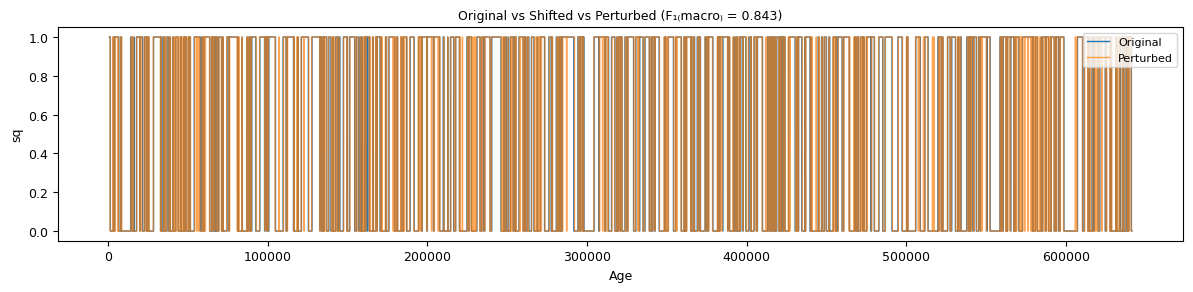

Perturbed F₁ score: 0.843


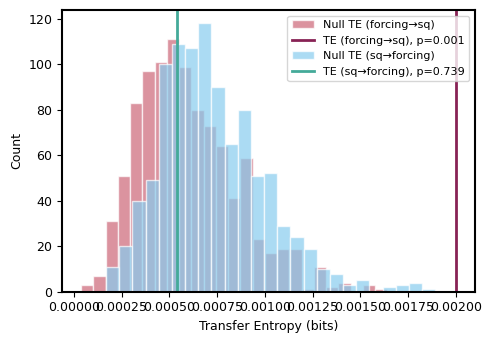

In [14]:
from toolbox import syn_test as syn_t
import importlib; 
importlib.reload(syn_t)


df_pert, f1 = syn_t.perturb_sequence_v2(df_sq, n_events=250, min_len=3, max_len=6, trans_shift=4, plot=True)
print(f"Perturbed F₁ score: {f1:.3f}")


pre = df_pre_i['pre'].values
sq  = df_pert['sq'].values

result, fig = sa.transfer_entropy_surrogate_test(
    pre, sq,
    forcing_bins=6, sq_bins=2,
    sq_method='quantile',
    binary=True,
    n_surr=1000
)


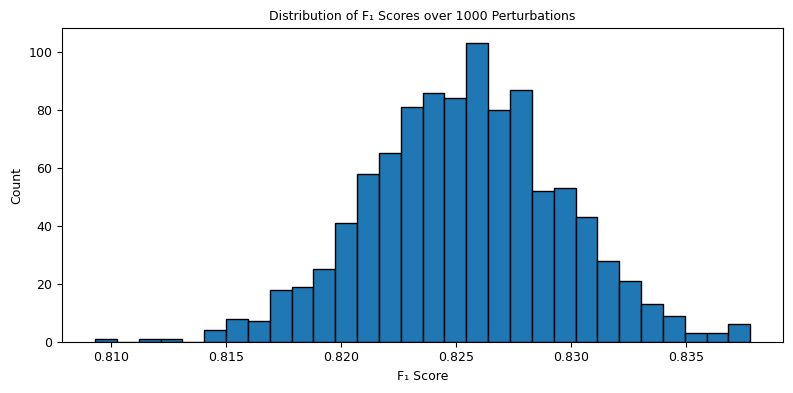

TE test was significant in 99.5% of the 1000 runs


In [16]:
import numpy as np
import matplotlib.pyplot as plt
from toolbox import syn_test as syn_t
import importlib; 
importlib.reload(syn_t)


n_iter = 1000
f1_scores = []
sig_flags = []

pre = df_pre_i['pre'].values

for i in range(n_iter):
    # 1) perturb (no plot, seed=i for reproducibility)
    df_pert, f1 = syn_t.perturb_sequence_v2(df_sq, n_events=250, min_len=2, max_len=10, trans_shift=4, plot=False)
    f1_scores.append(f1)

    # 2) re‐run TE

    sq  = df_pert['sq'].values

    result, _ = sa.transfer_entropy_surrogate_test(
        pre, sq,
        forcing_bins=6,
        sq_bins=2,
        sq_method='quantile',
        binary=True,
        n_surr=1000,
        if_plot=False,
    )

    # 3) result is already a bool
    sig_flags.append(bool(result))

# Plot histogram of F1 scores
plt.figure(figsize=(8, 4))
plt.hist(f1_scores, bins=30, edgecolor='k')
plt.xlabel('F₁ Score')
plt.ylabel('Count')
plt.title(f'Distribution of F₁ Scores over {n_iter} Perturbations')
plt.tight_layout()
plt.show()

# Print percentage significant
percent_sig = np.mean(sig_flags) * 100
print(f"TE test was significant in {percent_sig:.1f}% of the {n_iter} runs")


Requested erase_portion=0.40: Removed 204/511 transitions, 223 remain.


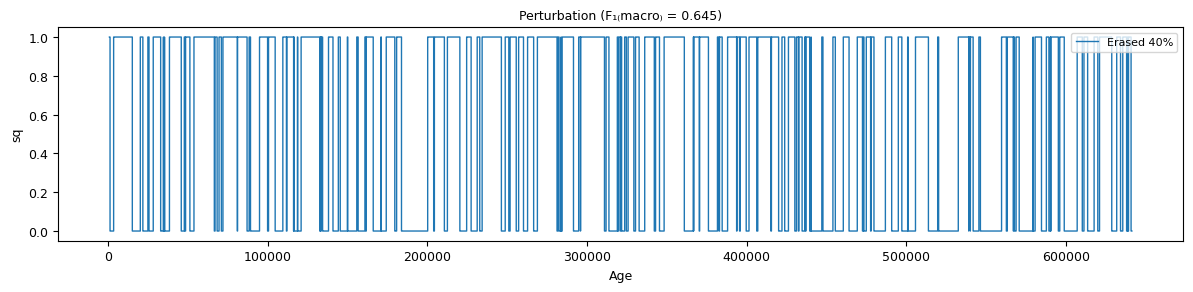

Perturbed F₁ score: 0.645


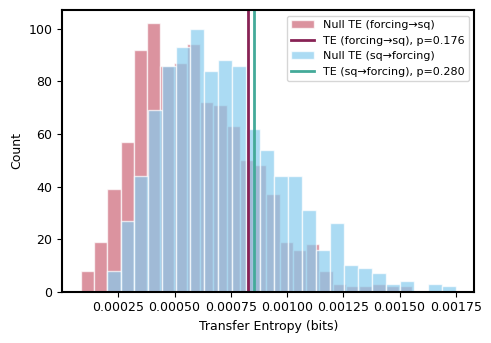

In [103]:
from toolbox import syn_test as syn_t
import importlib; 
importlib.reload(syn_t)


df_pert, f1 = syn_t.perturb_sequence_random_erase(df_sq, n_events=250, min_len=3, max_len=6, trans_shift=4, erase_portion=0.4, plot=True)
print(f"Perturbed F₁ score: {f1:.3f}")


pre = df_pre_i['pre'].values
sq  = df_pert['sq'].values

result, fig = sa.transfer_entropy_surrogate_test(
    pre, sq,
    forcing_bins=6, sq_bins=2,
    sq_method='quantile',
    binary=True,
    n_surr=1000
)

In [106]:
import numpy as np
import matplotlib.pyplot as plt
from toolbox import syn_test as syn_t
import importlib; 
importlib.reload(syn_t)


n_iter = 1000
f1_scores = []
sig_flags = []

pre = df_pre_i['pre'].values

for i in range(n_iter):
    # 1) perturb (no plot, seed=i for reproducibility)
    df_pert, f1 = syn_t.perturb_sequence_random_erase(df_sq, n_events=250, min_len=2, max_len=10, trans_shift=4, erase_portion=0.3, plot=False)
    f1_scores.append(f1)

    # 2) re‐run TE

    sq  = df_pert['sq'].values

    result, _ = sa.transfer_entropy_surrogate_test(
        pre, sq,
        forcing_bins=6,
        sq_bins=2,
        sq_method='quantile',
        binary=True,
        n_surr=1000,
        if_plot=False,
    )

    # 3) result is already a bool
    sig_flags.append(bool(result))

# # Plot histogram of F1 scores
# plt.figure(figsize=(8, 4))
# plt.hist(f1_scores, bins=30, edgecolor='k')
# plt.xlabel('F₁ Score')
# plt.ylabel('Count')
# plt.title(f'Distribution of F₁ Scores over {n_iter} Perturbations')
# plt.tight_layout()
# plt.show()

# Print percentage significant
percent_sig = np.mean(sig_flags) * 100
print(f"TE test was significant in {percent_sig:.1f}% of the {n_iter} runs")


Requested erase_portion=0.30: Removed 153/511 transitions, 269 remain.
Requested erase_portion=0.30: Removed 153/511 transitions, 265 remain.
Requested erase_portion=0.30: Removed 153/511 transitions, 267 remain.
Requested erase_portion=0.30: Removed 153/511 transitions, 273 remain.
Requested erase_portion=0.30: Removed 153/511 transitions, 285 remain.
Requested erase_portion=0.30: Removed 153/511 transitions, 275 remain.
Requested erase_portion=0.30: Removed 153/511 transitions, 288 remain.
Requested erase_portion=0.30: Removed 153/511 transitions, 277 remain.
Requested erase_portion=0.30: Removed 153/511 transitions, 277 remain.
Requested erase_portion=0.30: Removed 153/511 transitions, 273 remain.
Requested erase_portion=0.30: Removed 153/511 transitions, 291 remain.
Requested erase_portion=0.30: Removed 153/511 transitions, 274 remain.
Requested erase_portion=0.30: Removed 153/511 transitions, 280 remain.
Requested erase_portion=0.30: Removed 153/511 transitions, 273 remain.
Reques

Requested erase_portion=0.10: Removed 51/511 transitions, 411 remain.
Requested erase_portion=0.10: Removed 51/511 transitions, 409 remain.
Requested erase_portion=0.10: Removed 51/511 transitions, 419 remain.
Requested erase_portion=0.10: Removed 51/511 transitions, 419 remain.
Requested erase_portion=0.10: Removed 51/511 transitions, 413 remain.
Requested erase_portion=0.10: Removed 51/511 transitions, 423 remain.
Requested erase_portion=0.10: Removed 51/511 transitions, 413 remain.
Requested erase_portion=0.10: Removed 51/511 transitions, 421 remain.
Requested erase_portion=0.10: Removed 51/511 transitions, 419 remain.
Requested erase_portion=0.10: Removed 51/511 transitions, 421 remain.
Requested erase_portion=0.10: Removed 51/511 transitions, 421 remain.
Requested erase_portion=0.10: Removed 51/511 transitions, 419 remain.
Requested erase_portion=0.10: Removed 51/511 transitions, 415 remain.
Requested erase_portion=0.10: Removed 51/511 transitions, 419 remain.
Requested erase_port

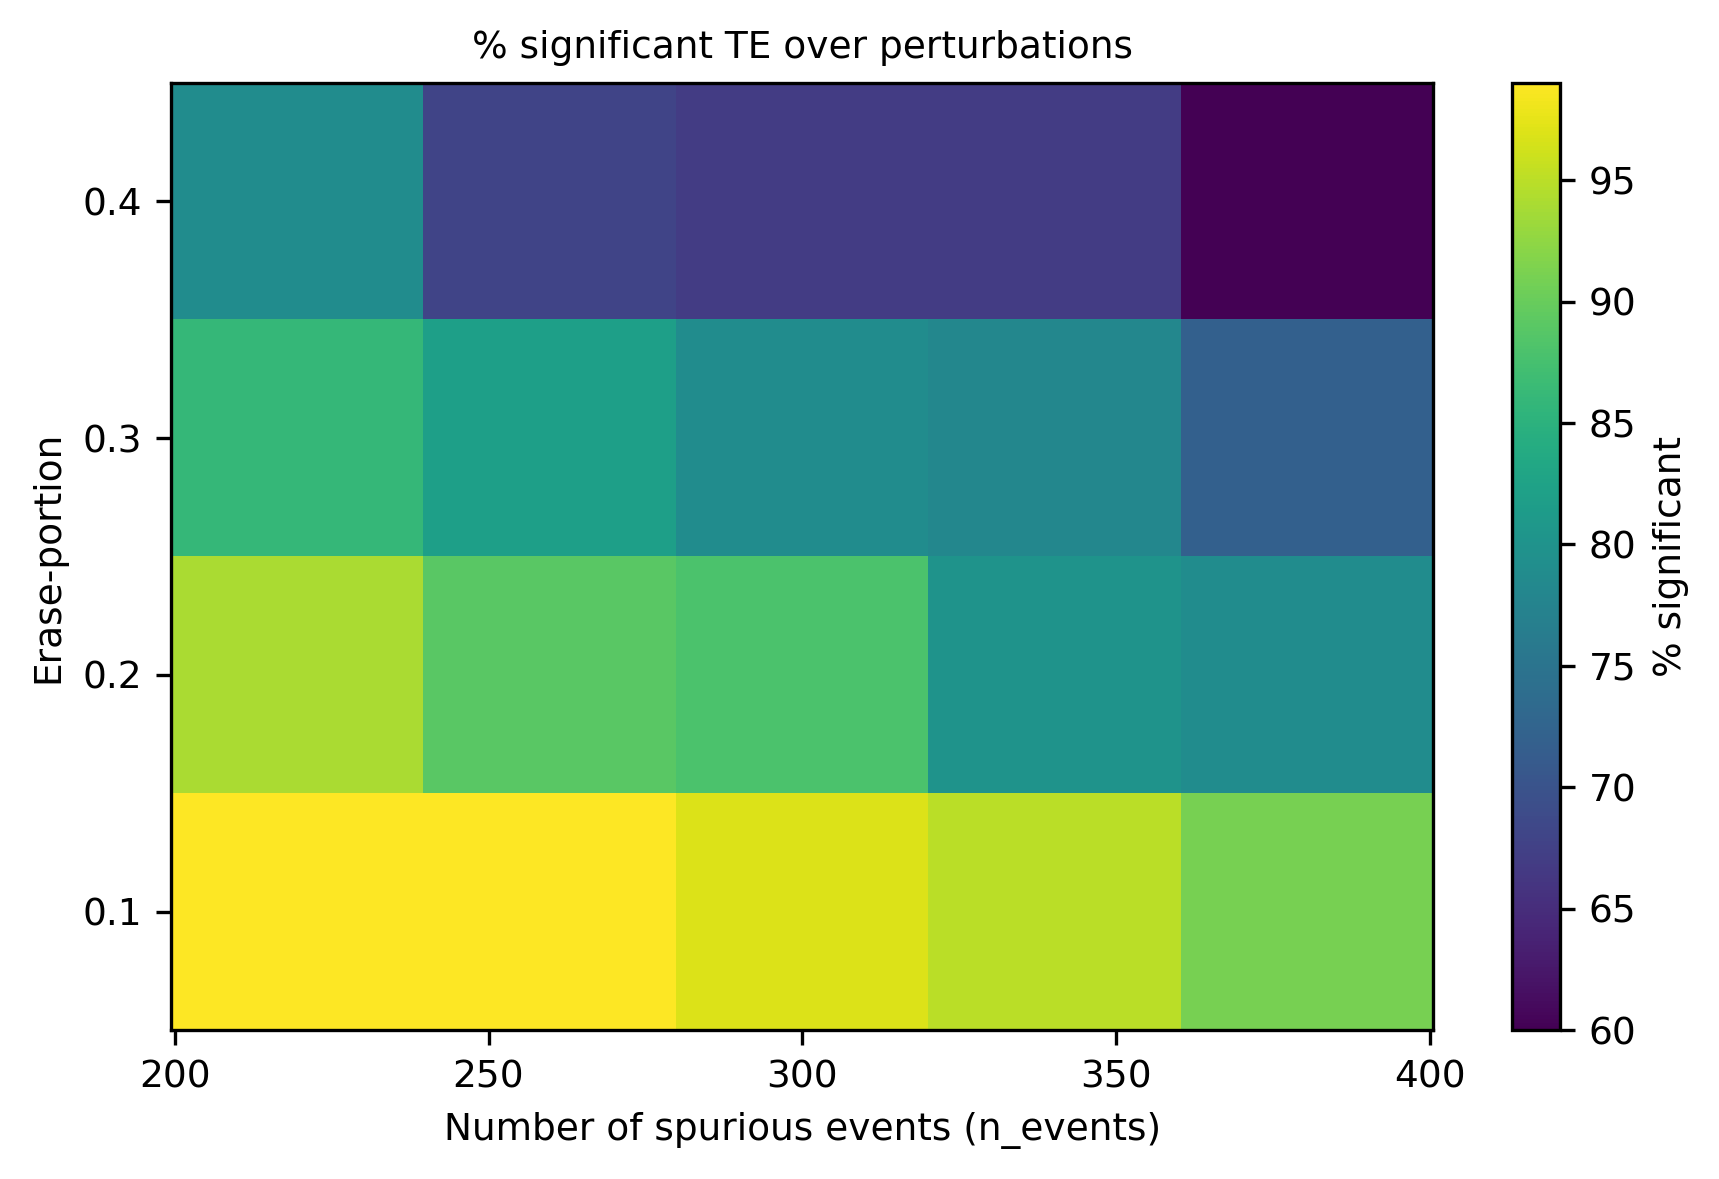

In [105]:
import numpy as np
import matplotlib.pyplot as plt
from toolbox import syn_test as syn_t
import importlib; importlib.reload(syn_t)

# parameters
n_iter        = 100
n_events_list = list(range(200, 401, 50))      # 200, 250, 300, 350, 400
erase_list    = [0.1, 0.2, 0.3, 0.4]           # 0.1 → 0.4
tol           = 500                            # your TE tolerance
forcing_bins  = 6
sq_bins       = 2
sq_method     = 'quantile'
binary        = True
n_surr        = 1000

# pre‐extracted forcing record
pre = df_pre_i['pre'].values

# allocate result matrix (rows=erase, cols=n_events)
percent_sig = np.zeros((len(erase_list), len(n_events_list)))

for i, erase_portion in enumerate(erase_list):
    for j, n_events in enumerate(n_events_list):
        sig_flags = []

        for seed in range(n_iter):
            # 1) perturb
            df_pert, _ = syn_t.perturb_sequence_random_erase(
                df_sq,
                n_events=n_events,
                min_len=2,
                max_len=10,
                trans_shift=4,
                erase_portion=erase_portion,
                random_state=seed,
                plot=False
            )
            sq = df_pert['sq'].values

            # 2) TE test
            result, _ = sa.transfer_entropy_surrogate_test(
                pre, sq,
                forcing_bins=forcing_bins,
                sq_bins=sq_bins,
                sq_method=sq_method,
                binary=binary,
                n_surr=n_surr,
                if_plot=False,
            )
            sig_flags.append(bool(result))

        # store percent significant
        percent_sig[i, j] = 100 * np.mean(sig_flags)

# --- plot heatmap ---
plt.figure(figsize=(6, 4), dpi=300)
im = plt.imshow(percent_sig, 
                origin='lower', 
                aspect='auto',
                extent=[min(n_events_list)-0.5, max(n_events_list)+0.5,
                        min(erase_list)-0.05,  max(erase_list)+0.05])

# ticks
plt.xticks(n_events_list)
plt.yticks(erase_list)

plt.xlabel('Number of spurious events (n_events)')
plt.ylabel('Erase‐portion')
plt.title('% significant TE over perturbations')
plt.colorbar(im, label='% significant')

plt.grid(False)
plt.tight_layout()
plt.show()


# Random perturb + random noise + random flip

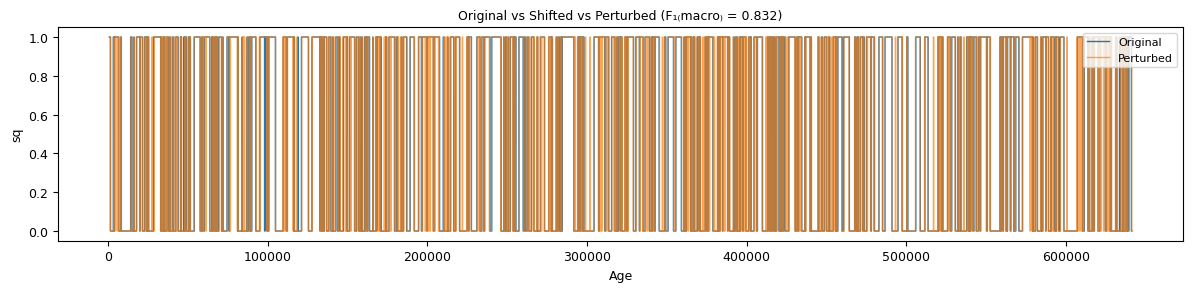

Perturbed F₁ score: 0.832


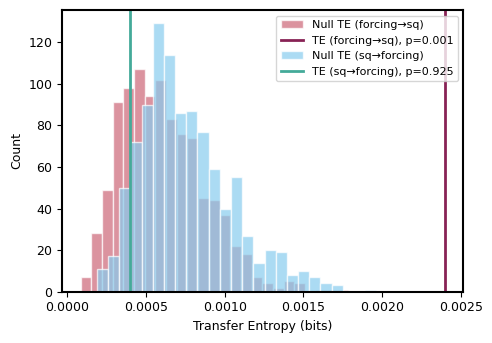

In [20]:
from toolbox import syn_test as syn_t
import importlib; 
importlib.reload(syn_t)


df_pert, f1 = syn_t.perturb_sequence_random_flip(df_sq, n_events=250, min_len=3, max_len=6, trans_shift=4, flip_portion=0.3, plot=True)
print(f"Perturbed F₁ score: {f1:.3f}")


pre = df_pre_i['pre'].values
sq  = df_pert['sq'].values

result, fig = sa.transfer_entropy_surrogate_test(
    pre, sq,
    forcing_bins=6, sq_bins=2,
    sq_method='quantile',
    binary=True,
    n_surr=1000
)


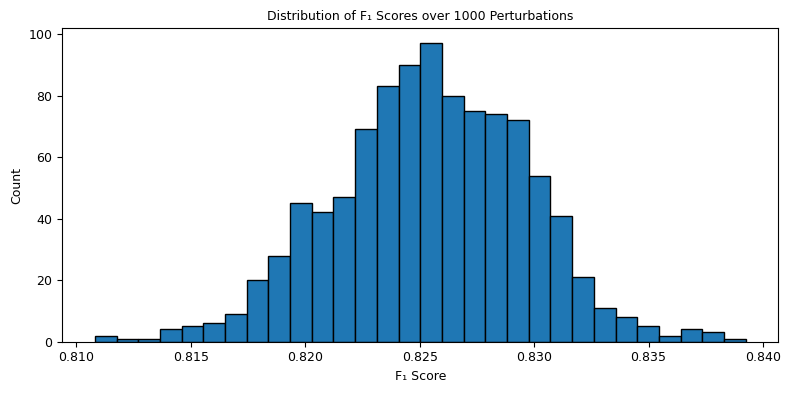

TE test was significant in 99.6% of the 1000 runs


In [21]:
import numpy as np
import matplotlib.pyplot as plt
from toolbox import syn_test as syn_t
import importlib; 
importlib.reload(syn_t)


n_iter = 1000
f1_scores = []
sig_flags = []

pre = df_pre_i['pre'].values

for i in range(n_iter):
    # 1) perturb (no plot, seed=i for reproducibility)
    df_pert, f1 = syn_t.perturb_sequence_random_flip(df_sq, n_events=250, min_len=2, max_len=10, trans_shift=4, flip_portion=0.3, plot=False)
    f1_scores.append(f1)

    # 2) re‐run TE

    sq  = df_pert['sq'].values

    result, _ = sa.transfer_entropy_surrogate_test(
        pre, sq,
        forcing_bins=6,
        sq_bins=2,
        sq_method='quantile',
        binary=True,
        n_surr=1000,
        if_plot=False,
    )

    # 3) result is already a bool
    sig_flags.append(bool(result))

# Plot histogram of F1 scores
plt.figure(figsize=(8, 4))
plt.hist(f1_scores, bins=30, edgecolor='k')
plt.xlabel('F₁ Score')
plt.ylabel('Count')
plt.title(f'Distribution of F₁ Scores over {n_iter} Perturbations')
plt.tight_layout()
plt.show()

# Print percentage significant
percent_sig = np.mean(sig_flags) * 100
print(f"TE test was significant in {percent_sig:.1f}% of the {n_iter} runs")


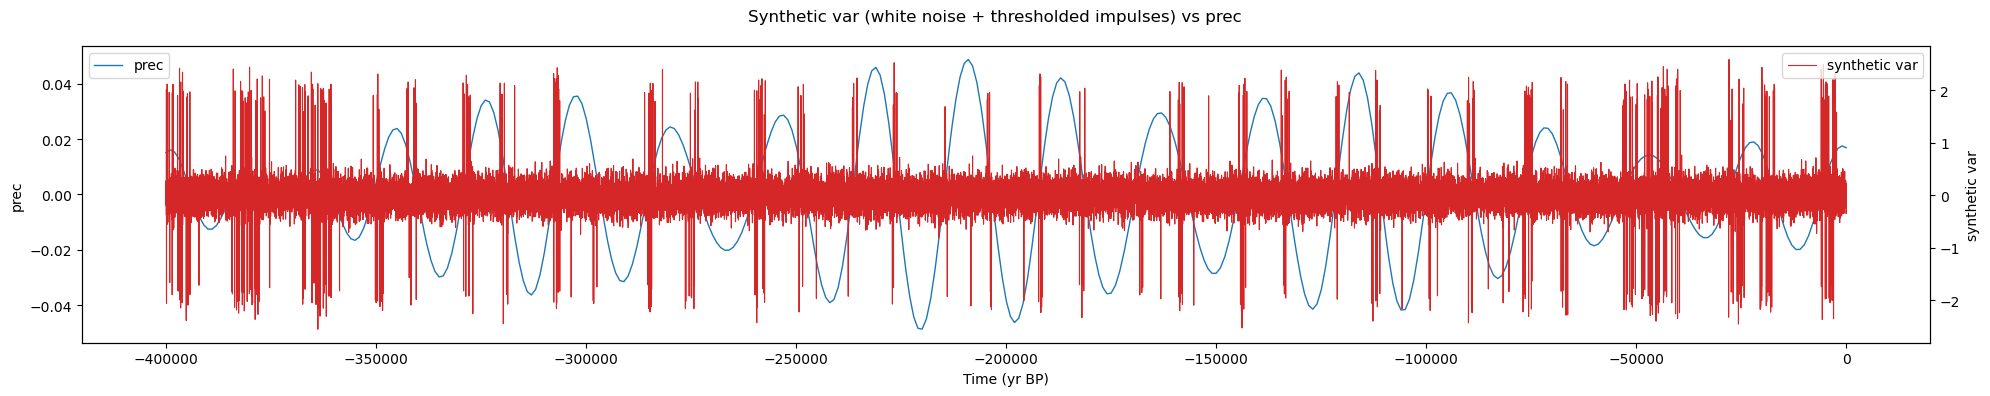

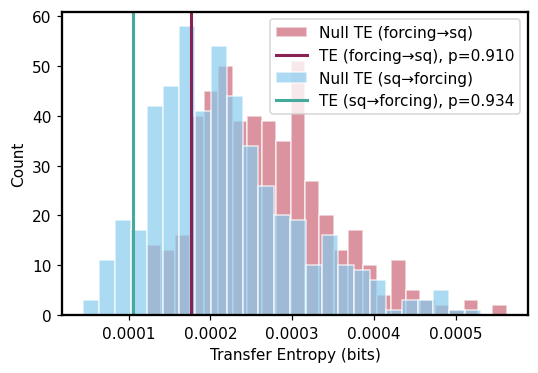


Unidirectional significance (prec → var only) ? False


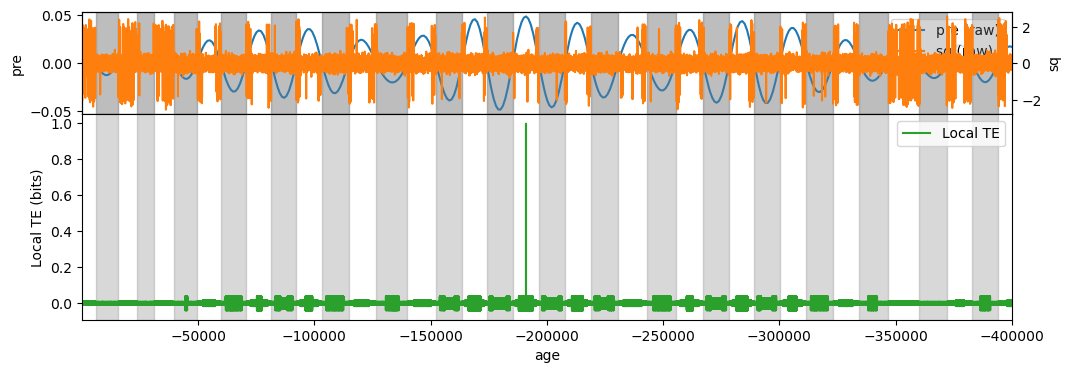

First 10 local-TE values: [[ 0.00854544  0.00854544 -0.00865373 ...  0.01536105 -0.00362336
   0.00370817]]


In [30]:
# -------------------------------------------------------------------
# 0.  Prerequisites:  time  &  prec  must already exist
# -------------------------------------------------------------------
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Synthetic-signal hyper-parameters
np.random.seed(2025)
baseline_std  = 0.2         # σ of white noise
impulse_amp   = 2.0           # absolute spike size
p_lo          = 0.001         # impulse prob outside favoured window
p_hi          = 0.050         # impulse prob inside favoured window

# -------------------------------------------------------------------
# 1.  Build the synthetic var (white-noise + thresholded impulses)
# -------------------------------------------------------------------
prec_norm = (prec - prec.min()) / (prec.max() - prec.min())  # rescale 0‒1

# logical mask:  true if normalized prec ∈ (3/6, 4/6]
favoured = (prec_norm > 3/6) & (prec_norm <= 4/6)

# Draw random impulses
rnd = np.random.rand(len(prec))
impulses = np.zeros_like(prec)

# where favoured, use p_hi; elsewhere p_lo
mask_hi = favoured & (rnd < p_hi)
mask_lo = (~favoured) & (rnd < p_lo)

# assign ±impulse_amp with equal probability
impulses[mask_hi | mask_lo] = impulse_amp * np.where(
    np.random.rand(mask_hi.sum() + mask_lo.sum()) < 0.5, 1, -1
)

# final synthetic series
vartooth = np.random.normal(0, baseline_std, len(prec)) + impulses

# -------------------------------------------------------------------
# 2.  Plot prec (blue) & synthetic var (red)
# -------------------------------------------------------------------
fig, ax1 = plt.subplots(figsize=(20, 4))
ax2 = ax1.twinx()

ax1.plot(time, prec, lw=1, label='prec')
ax2.plot(time, vartooth, color='tab:red', lw=0.8, label='synthetic var')

ax1.set_xlabel('Time (yr BP)')
ax1.set_ylabel('prec')
ax2.set_ylabel('synthetic var')
fig.suptitle('Synthetic var (white noise + thresholded impulses) vs prec')
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')
plt.tight_layout()
plt.show()

# -------------------------------------------------------------------
# 3.  Reverse the series (MATLAB convention) & test transfer entropy
# -------------------------------------------------------------------
from toolbox import sq_ana as sa
import importlib; importlib.reload(sa)

forcing = prec[::-1]          # driver
sq      = vartooth[::-1]      # response

# --- 3.1  Surrogate-based TE test
unidir_prec_to_var, fig_te = sa.transfer_entropy_surrogate_test(
    forcing      = forcing,
    sq           = sq,
    k            = 1,
    forcing_bins = 6,
    sq_bins      = 2,
    n_surr       = 500,
    p            = 0.05,
    sq_method    = 'hist',
    if_plot      = True,
    dpi          = 110
)
print("\nUnidirectional significance (prec → var only) ?",
      unidir_prec_to_var)

# --- 3.2  Local-TE track
df_pre = pd.DataFrame({"age": time, "pre": forcing})
df_sq  = pd.DataFrame({"age": time, "sq":  sq})

local_te_vals = sa.local_TE(
    df_pre          = df_pre,
    df_sq           = df_sq,
    forcing_column  = "pre",
    target_column   = "sq",
    time_column     = "age",
    nbins_pre       = 6,
    nbins_target    = 2
)

print("First 10 local-TE values:", local_te_vals[:10])


      Direction  Transfer Entropy (bits)  p-value (shuffle)  Significant? (α = 0.05)
prec → vartooth                 0.002297           0.001996                     True
vartooth → prec                 0.000088           0.908184                    False


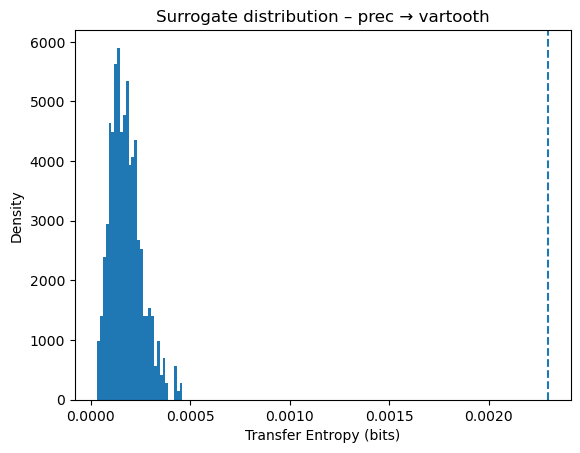

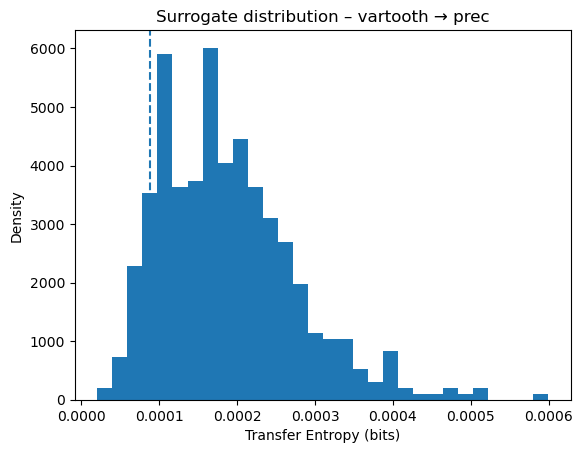

In [17]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import sawtooth
from scipy.interpolate import interp1d
from typing import Optional
from pyinform import transfer_entropy


# ------------------------------------------------------------------------
# 2.  DISCRETISE (6 bins for prec, 2 bins for vartooth)
# ------------------------------------------------------------------------
def discretise(series: np.ndarray, bins: int) -> np.ndarray:
    """
    Equal-frequency binning → integers in [0, bins-1], guaranteed non-negative.
    Works on Python ≥3.6 (no PEP-604 types).
    """
    edges = np.quantile(series, np.linspace(0, 1, bins + 1))
    edges[0], edges[-1] = -np.inf, np.inf          # capture extremes
    labels = np.digitize(series, edges[1:-1])      # 0 … bins
    return np.clip(labels, 0, bins - 1).astype(np.int32)

prec_d     = discretise(prec,      bins=6)
vartooth_d = discretise(vartooth,  bins=2)

# ------------------------------------------------------------------------
# 3.  TRANSFER ENTROPY WITH SURROGATE TEST
# ------------------------------------------------------------------------
def te_with_surrogates(src: np.ndarray,
                       dst: np.ndarray,
                       k: int = 1,
                       nsurr: int = 500,
                       random_state: Optional[int] = None):
    """
    TE(src→dst) + shuffle-surrogate p-value (one-sided).
    Returns (observed_TE, p_value, surrogate_TEs)
    """
    rng = np.random.default_rng(random_state)
    te_obs = transfer_entropy(src, dst, k=k)

    surrogates = np.empty(nsurr, dtype=float)
    for i in range(nsurr):
        surrogates[i] = transfer_entropy(rng.permutation(src), dst, k=k)

    p_val = (np.count_nonzero(surrogates >= te_obs) + 1) / (nsurr + 1)
    return te_obs, p_val, surrogates

k, nsurr = 1, 500
te_fw, p_fw, surr_fw = te_with_surrogates(prec_d,     vartooth_d, k, nsurr, random_state=42)
te_bw, p_bw, surr_bw = te_with_surrogates(vartooth_d, prec_d,     k, nsurr, random_state=43)

# ------------------------------------------------------------------------
# 4.  RESULTS SUMMARY
# ------------------------------------------------------------------------
results = pd.DataFrame({
    "Direction"             : ["prec → vartooth", "vartooth → prec"],
    "Transfer Entropy (bits)": [te_fw, te_bw],
    "p-value (shuffle)"      : [p_fw, p_bw],
    "Significant? (α = 0.05)" : [p_fw < 0.05, p_bw < 0.05],
})
print(results.to_string(index=False))

# ------------------------------------------------------------------------
# 5.  OPTIONAL – plot surrogate distributions
# ------------------------------------------------------------------------
plt.figure()
plt.hist(surr_fw, bins=30, density=True)
plt.axvline(te_fw, ls="--")
plt.title("Surrogate distribution – prec → vartooth")
plt.xlabel("Transfer Entropy (bits)"); plt.ylabel("Density")

plt.figure()
plt.hist(surr_bw, bins=30, density=True)
plt.axvline(te_bw, ls="--")
plt.title("Surrogate distribution – vartooth → prec")
plt.xlabel("Transfer Entropy (bits)"); plt.ylabel("Density")

plt.show()
